In [45]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim
import numpy as np

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

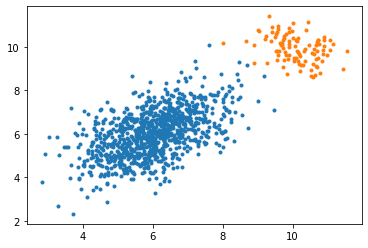

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = [6, 6]
cov = [[1, 0.5], [0.5, 1]]  # diagonal covariance

mean1 = [10, 10]
cov1 = [[0.5, -0.2], [-0.2, 0.5]]  # diagonal covariance

x_normal = np.random.multivariate_normal(mean, cov, 1000)
x_ab = np.random.multivariate_normal(mean1, cov1, 100)

plt.plot(x_normal[:,0], x_normal[:,1], '.')
plt.plot(x_ab[:,0], x_ab[:,1], '.')

# x, y = datasets.make_moons(1000, noise=.05)
# plt.scatter(x[:, 0], x[:, 1]);
num_layers = 5
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
flow.to(device)
optimizer = optim.Adam(flow.parameters(), lr = 1e-3)

In [47]:
num_iter = 1000
for i in range(num_iter):
#     x, y = datasets.make_moons(1000, noise=.05)
    x = torch.tensor(x_normal, dtype=torch.float32).to(device)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 100 == 0:
        print(i,loss)
#         xline = torch.linspace(0, 12, 1000)
# #         yline = torch.linspace(-.75, 1.25)
# #         xgrid, ygrid = torch.meshgrid(xline, yline)
# #         xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

#         with torch.no_grad():
#             zgrid = flow.log_prob(xline).exp().reshape(100, 100)

#         plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
#         plt.title('iteration {}'.format(i + 1))
#         plt.show()

99 tensor(6.7825, grad_fn=<NegBackward>)
199 tensor(3.9882, grad_fn=<NegBackward>)
299 tensor(2.8158, grad_fn=<NegBackward>)
399 tensor(2.7831, grad_fn=<NegBackward>)
499 tensor(2.7774, grad_fn=<NegBackward>)
599 tensor(2.7747, grad_fn=<NegBackward>)
699 tensor(2.7731, grad_fn=<NegBackward>)
799 tensor(2.7722, grad_fn=<NegBackward>)
899 tensor(2.7716, grad_fn=<NegBackward>)
999 tensor(2.7713, grad_fn=<NegBackward>)


(array([0.00719756, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00719758, 0.00719756, 0.00719758,
        0.        , 0.00719758, 0.        , 0.00719758, 0.01439516,
        0.00719758, 0.        , 0.00719758, 0.01439516, 0.00719758,
        0.01439516, 0.        , 0.02879032, 0.00719758, 0.        ,
        0.02159267, 0.03598791, 0.03598791, 0.04318549, 0.09356855,
        0.03598791, 0.07917339, 0.06477823, 0.12235888, 0.1511492 ,
        0.10796372, 0.10076614, 0.23751977, 0.25191534, 0.21592743,
        0.28070566, 0.30949599, 0.33108873, 0.40306454, 0.42465728,
        0.5758055 , 0.67657262, 0.6837702 , 0.88530247, 0.88530247]),
 array([-8.736563 , -8.597627 , -8.458692 , -8.319756 , -8.18082  ,
        -8.041884 , -7.9029493, -7.764014 , -7.625078 , -7.486142 ,
        -7.3472066, -7.208271 , -7.0693355, -6.9304   , -6.7914643,
        -6.652529 , -6.513593 , -6.3746576, -6.235722 , -6.0967865,
        -5.957851 , -5.8189154, -5.67998  , -5

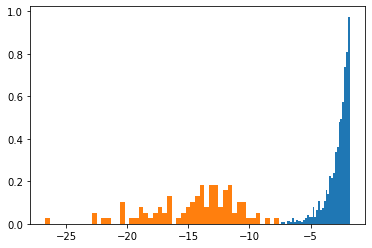

<Figure size 432x288 with 0 Axes>

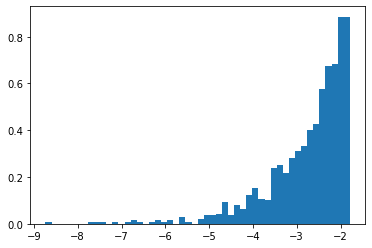

In [71]:
# log probability of training data 

log_p_normal = flow.log_prob(torch.Tensor(x_normal))
plt.figure()
plt.hist(log_p_normal.detach().numpy(), 50,density=True)
# print(log_p_normal.detach().sort())

log_p_ab = flow.log_prob(torch.Tensor(x_ab))
# plt.figure()
plt.hist(log_p_ab.detach().numpy(), 50,density=True)

samples0 = flow.sample(1000)
samples = samples0.detach().numpy()
plt.figure()
# plt.plot(samples[:,0], samples[:,1],'.')

log_p_new = flow.log_prob(samples0)
plt.figure()
plt.hist(log_p_new.detach().numpy(), 50,density=True)